In [26]:
import jax
import jax.numpy as jnp
import jax.random as random

import jax_cosmo as jc

import numpyro
from numpyro import sample
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoMultivariateNormal
from numpyro.infer import init_to_value, Trace_ELBO, SVI
from optax import adam

import matplotlib.pyplot as plt

import arviz as az

import numpy as np

import emcee as em

In [2]:
key = random.PRNGKey(3141)
key, subkey, subkey2, subkey3 = random.split(key, 4)

## Creating some data

In [3]:
shape = (2000,)
z_random = random.uniform(key, shape, minval=0.01, maxval=1.5)
z = jnp.sort(z_random)

In [4]:
true_param = {'h':0.7,
    'Omega_m':0.29,
    'w0':-1.02,
    'wa':0.01}

In [5]:
def distance_modulus(theta, z):
    a = jc.utils.z2a(z)
    h = theta.get('h', 0.7)
    Omega_m = theta.get('Omega_m', 0.3)
    Omega_b = 0.05
    Omega_c = Omega_m - Omega_b
    Omega_k = theta.get('Omega_k', 0.)
    w0 = theta.get('w0', -1.)
    wa = theta.get('wa', 0.)
    
    cosmology = jc.Cosmology(h=h, Omega_c=Omega_c, Omega_b=Omega_b, w0=w0, wa=wa, Omega_k=Omega_k, n_s=0.96, sigma8=0.83)
    dist_L = (jc.background.angular_diameter_distance(cosmology, a)/a**2)/h
    dist_mod = 25 + 5 * jnp.log10(dist_L)
    return dist_mod

In [6]:
sigma = 0.1 * jnp.log(1+z)
dist_mod_err = sigma * random.uniform(subkey, shape, minval=-1, maxval=1) 

cov = jnp.diag(sigma**2)

In [7]:
dist_mod = distance_modulus(true_param, z) + dist_mod_err

/home/jakob/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


Text(0, 0.5, 'distance modulus')

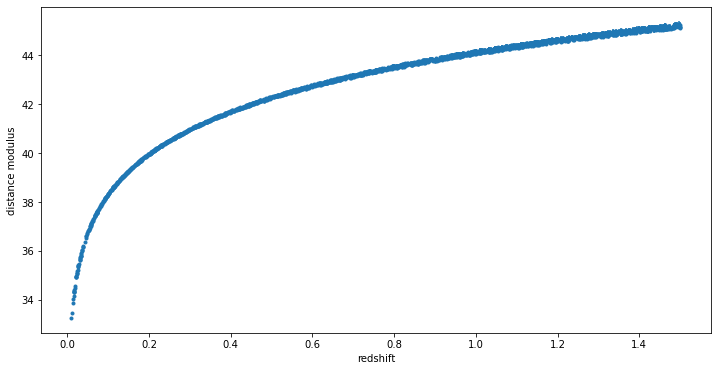

In [8]:
plt.figure(figsize=(12,6))
plt.errorbar(z, dist_mod, yerr = sigma, marker='.', linestyle='')
plt.xlabel('redshift')
plt.ylabel('distance modulus')

## Setting up the model

In [43]:
def model_cpl(x, y, sig):
    cov = jnp.diag(sig**2)
    Omega_m = sample("Omega_m", dist.Uniform(0,1))
    w0 = sample("w0", dist.Uniform(-10, 10))
    wa = sample("wa", dist.Uniform(-10,10))
    theta_dict = {"Omega_m":Omega_m, "w0":w0, "wa":wa}
    mu = distance_modulus(theta_dict, x)
    
    sample("y", dist.MultivariateNormal(mu, cov), obs=y)

## Running the optimizer

In [10]:
initial_values = {'Omega_m':0.5, 'w0':-1., 'wa':0.}

In [11]:
guide_cpl = AutoMultivariateNormal(model_cpl, 
                                   init_loc_fn = init_to_value(values=initial_values))

In [44]:
svi = SVI(model_cpl, 
    guide_cpl, 
    adam(0.01), 
    Trace_ELBO(),     
    x = z,
    y = dist_mod,
    sig = sigma
)

In [ ]:
svi_result = svi.run(subkey2, 5000)

/home/jakob/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
 54%|██████████▎        | 2707/5000 [03:12<03:31, 10.86it/s, init loss: 23320.5801, avg. loss [2251-2500]: -4048.6042]

In [15]:
samples = guide_cpl.sample_posterior(subkey3, svi_result.params, (100000,))
idata_num = az.from_dict(samples)

In [16]:
az.summary(idata_num, kind='stats')

,mean,sd,hdi_3%,hdi_97%
Omega_m,0.415,0.013,0.391,0.440
w0,-1.163,0.148,-1.445,-0.888
wa,-2.950,1.304,-5.354,-0.499


array([[<AxesSubplot:ylabel='$\\Omega_{m,0}$'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='$w_0$'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='$\\Omega_{m,0}$', ylabel='$w_a$'>,
        <AxesSubplot:xlabel='$w_0$'>, <AxesSubplot:xlabel='$w_a$'>]],
      dtype=object)

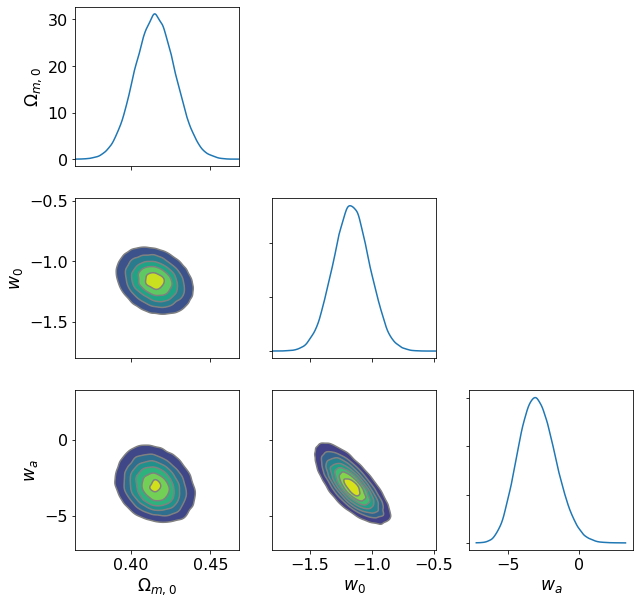

In [18]:
var_dict = {"Omega_m" : r"$\Omega_{m,0}$",
               "w0" :  r"$w_0$",
               "wa" : r"$w_a$"}   

labeller = az.labels.MapLabeller(var_name_map=var_dict)

az.plot_pair(idata_num, kind='kde', marginals=True, figsize=(10,10), textsize=16, contour=False, labeller=labeller)

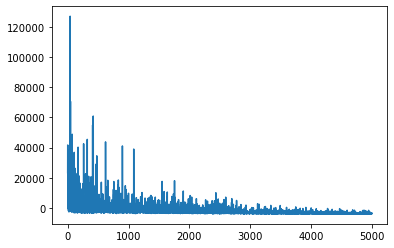

In [19]:
plt.plot(svi_result.losses)

/home/jakob/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


Text(0, 0.5, 'distance modulus')

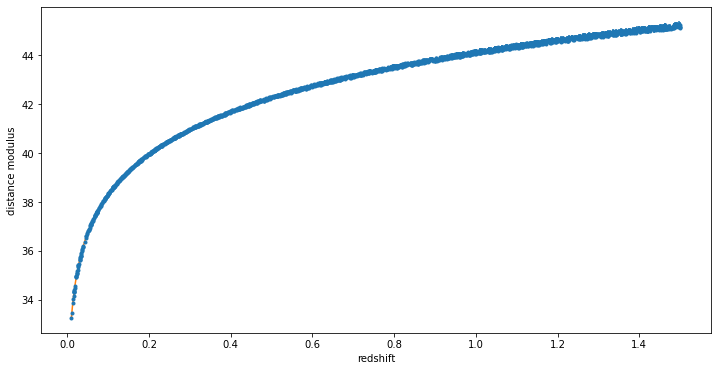

In [20]:
plt.figure(figsize=(12,6))
plt.errorbar(z, dist_mod, yerr = sigma, marker='.', linestyle='')
plt.plot(z, distance_modulus({'Omega_m':0.385, 'w0':-0.993, 'wa':-3.02}, z))
plt.xlabel('redshift')
plt.ylabel('distance modulus')

In [36]:
from numpyro.infer import MCMC, NUTS

In [40]:
mcmc_key = random.PRNGKey(1234)
kernel = NUTS(model_cpl)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, z, dist_mod, sigma)
mcmc.print_summary()

/home/jakob/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
sample: 100%|██████████████████████████| 1000/1000 [06:06<00:00,  2.73it/s, 39 steps of size 6.66e-02. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.30      0.07      0.32      0.19      0.39    114.78      1.00
        w0     -1.02      0.07     -1.02     -1.12     -0.89    167.20      1.00
        wa     -0.53      1.10     -0.34     -2.12      1.04    115.78      1.00

Number of divergences: 1


## emcee

In [29]:
def log_likelihood(x, y, sig, theta_dict):
    distance_mod = distance_modulus(theta_dict, x)
    log_like = -0.5 * ((y - distance_mod)**2/sig**2)
    return log_like

In [30]:
def log_prior(Omega_m=0.3, w_0=-1, w_1=0):
    '''returns the log of the propability densities up to a constant'''
    if 0.0 < Omega_m < 1:
        return -((w_0+1)**2/5**2 + (w_1)**2/5**2) 
    return -np.inf

In [33]:
def log_probability(theta,x, y, sig):
    '''performs the multiplication prior*likelihood'''
    keys = ['Omega_m', 'w_0', 'w_1']
    theta_dict = dict(zip(keys, theta))
    lp = log_prior(**theta_dict)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood( x, y, sig, theta_dict)

In [35]:
#print(name+' started...')
nwalkers = 8
initial = [0.3, -1, 0]
ndim = len(initial)
pos = initial + 0.05 * np.random.randn(nwalkers, ndim) 


sampler = em.EnsembleSampler(
nwalkers, ndim, log_probability, args=(np.array(z), np.array(dist_mod), np.array(sigma))#, backend=backend
)
sampler.run_mcmc(pos, 10000, progress=True);
samples = sampler.get_chain(flat=True)

/home/jakob/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
  0%|                                                                                       | 0/10000 [00:00<?, ?it/s]/home/jakob/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._chec

emcee: Exception while calling your likelihood function:
  params: [ 0.20850932 -0.9733811  -0.00578345]
  args: (array([0.01022949, 0.01116165, 0.01366114, ..., 1.4987795 , 1.4995131 ,
       1.499763  ], dtype=float32), array([33.25486 , 33.44337 , 33.88264 , ..., 45.259686, 45.12522 ,
       45.154716], dtype=float32), array([0.00101775, 0.00110999, 0.00135687, ..., 0.09158024, 0.0916096 ,
       0.0916196 ], dtype=float32))
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:
idata_em = az.from_emcee(sampler, var_names=var_names)